## XGBoost Matchup Predictor
By: Jackson Isidor and Alex Sullivan

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jacksonisidor/March-Madness-Predictor/main/MM%20Data/matchup_stats.csv")

In [3]:
df.head()

,Unnamed: 0,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,...,win_percent_2,winner,badj_em_diff,wab_diff,barthag_diff,talent_diff,elite_sos_diff,win_percent_diff,pppo_diff,k_off_diff
0,0,2023,Alabama,1,16,64,Texas A&M Corpus Chris,16,64,27.1,...,65.517241,1,28.9,16.2,0.505,62.286,24.154,19.776876,0.008,0.998
1,1,2023,Maryland,8,32,64,West Virginia,9,64,16.5,...,57.575758,1,-3.2,-0.5,-0.032,3.690,-6.315,6.060606,-0.002,0.056
2,2,2023,San Diego St.,5,2,64,College of Charleston,12,64,21.2,...,90.909091,1,9.7,4.1,0.137,37.036,16.740,-9.659091,-0.062,-5.790
3,3,2023,Virginia,4,64,64,Furman,13,32,16.9,...,77.419355,0,9.1,6.1,0.174,50.410,14.426,0.705645,-0.072,-7.131
4,4,2023,Creighton,6,8,64,North Carolina St.,11,64,21.0,...,69.696970,1,5.8,0.8,0.073,12.798,8.184,-6.060606,-0.020,-1.706


**Get the most important predictors using a feature from XGBoost:**

In [4]:
def getFeatures(allFeatures, j):
    
    bin_j = bin(j)[2:]
    bin_j = bin_j.zfill(len(allFeatures)) # adds leading zeros to match the length of allFeatures
    
    selected_features = []
    for feature, bit in zip(allFeatures, bin_j):
        if bit == "1":
            selected_features.append(feature)

    return selected_features

In [5]:

unique_years = df.year.unique()
np.random.shuffle(unique_years)
unique_years.size

15

In [6]:
## Make folds for each year

df_shuffled = df.sample(frac=1, random_state=42)

unique_years = df_shuffled.year.unique()
np.random.shuffle(unique_years)
k = unique_years.size
fold_indices = np.array_split(unique_years, k)
kf = KFold(n_splits=k)

In [7]:
df.columns[26:]

Index(['badj_em_diff', 'wab_diff', 'barthag_diff', 'talent_diff',
       'elite_sos_diff', 'win_percent_diff', 'pppo_diff', 'k_off_diff'],
      dtype='object')

In [8]:
X = df_shuffled[df.columns[26:]]
y = df_shuffled["winner"]

xgb = XGBClassifier()
xgb.fit(X, y)
xgb.feature_importances_

array([0.20633644, 0.19194263, 0.10099952, 0.10815375, 0.08616749,
       0.09863141, 0.10140386, 0.1063649 ], dtype=float32)

**Grid Search on XGBoost model to find the best parameters:**
- using the best feautures found above (badj_em_diff, wab_diff, barthag_diff, talent_diff, pppo_diff)

In [10]:
X = df_shuffled[df.columns[26:]]
y = df_shuffled["winner"]

pipeline = make_pipeline(StandardScaler(), XGBClassifier())

params = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],            
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2], 
    'xgbclassifier__subsample': [0.8, 0.9, 1.0],     
    'xgbclassifier__colsample_bytree': [0.8, 0.9, 1.0],
    'xgbclassifier__gamma': [0, 1, 5]                 
}

gs = GridSearchCV(pipeline,
                 param_grid = params,
                 scoring = 'accuracy',
                 cv = kf)

gs.fit(X, y)
gs.best_params_

{'xgbclassifier__colsample_bytree': 1.0,
 'xgbclassifier__gamma': 5,
 'xgbclassifier__learning_rate': 0.01,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__subsample': 1.0}

**Do cross validation with the best features and the best parameters:**

In [14]:
X = df_shuffled[df.columns[26:41]]
y = df_shuffled["winner"]

pipeline = make_pipeline(StandardScaler(), 
                         XGBClassifier(colsample_bytree=1,
                                       gamma=5,
                                       learning_rate=0.01,
                                       max_depth=3,
                                       n_estimators=100,
                                       subsample=1
                         ))

preds = cross_val_predict(pipeline,
                        X,
                        y,
                        cv=kf,
                        )

print(f"CV Accuracy: {accuracy_score(preds, y)}")

CV Accuracy: 0.7044491525423728


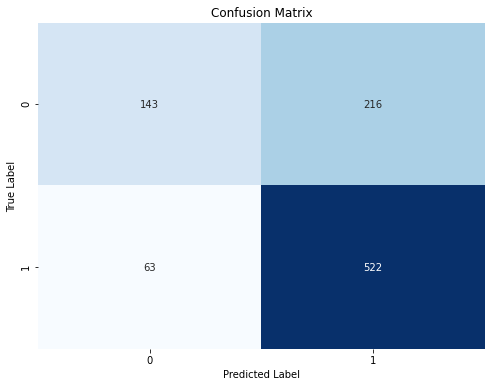

In [15]:
conf_matrix = confusion_matrix(y, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.69      0.40      0.51       359
           1       0.71      0.89      0.79       585

    accuracy                           0.70       944
   macro avg       0.70      0.65      0.65       944
weighted avg       0.70      0.70      0.68       944

